In [1]:
%%capture
import sys
!pip install category_encoders==2.*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

!pip install fbprophet
import fbprophet
from fbprophet import Prophet

In [3]:
# Named df1 so I can potentially add more years later (df1 is 2017 then years go down)
df1 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2017.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)
df2 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2016.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)
df3 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2015.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)
df4 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2014.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)
df5 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2013.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)

In [4]:
# Cleaning
def wrangle(df):
    df = df.copy()
    
    # drop the columns where there is no data for all of the 5 years
    cols = ['DEWP',	'VIS',	'TIDE', 'DPD']
    df.drop(columns=cols, inplace=True)
    
    
    # Drop the first two rows to make it only data from the year we want
    df = df.iloc[2:]

    # Reset the index
    df = df.reset_index()
    df.drop(columns='index', inplace=True)

    #Puts the date togetehr
    df['Date'] = df['#YY'] + '-' + df['MM'] + '-' + df['DD'] + ' ' + df['hh'] + ':' + df['mm']

    #converts date to a datetime object
    df['Date'] = pd.to_datetime(df['Date'])

    # Set the date as the index
    df = df.set_index('Date')
    df.head()

    # We can now remove the columns '#YY', 'DD', 'hh' * Leaving MM and hh because wind might be stronger in the morning than late at night or have seasonal variations.
    cols = ['#YY', 'DD', 'mm']
    df.drop(columns=cols, inplace=True)

    # Make the fataframe contain numberic values instrad of objects
    df = df.apply(lambda x: pd.to_numeric(x), axis=0)

    return df

In [5]:
df1 = wrangle(df1)
df2 = wrangle(df2)
df3 = wrangle(df3)
df4 = wrangle(df4)
df5 = wrangle(df5)

In [6]:
# Combine all of the dataframes into one
frames = [df5, df4, df3, df2, df1]
df = pd.concat(frames)

In [7]:
# Engineering a new feature for the difference between the airtemp and water temp
df['Temp_diff'] = abs(df['ATMP'] - df['WTMP'])
df.head()

,MM,hh,WDIR,WSPD,GST,WVHT,APD,MWD,PRES,ATMP,WTMP,Temp_diff
Date,,,,,,,,,,,,
2013-01-01 00:50:00,1,0,345,10.3,12.0,3.71,8.79,314,1017.4,22.1,24.1,2.0
2013-01-01 01:50:00,1,1,357,9.4,11.8,4.03,9.16,330,1017.9,22.4,24.1,1.7
2013-01-01 02:50:00,1,2,351,9.9,12.1,4.27,9.09,327,1018.7,22.3,24.1,1.8
2013-01-01 03:50:00,1,3,358,10.4,12.3,4.08,8.50,326,1019.3,22.1,24.1,2.0
2013-01-01 04:50:00,1,4,354,9.7,11.5,4.04,8.74,318,1020.0,21.9,24.1,2.2


In [8]:
# This is NOT using time series analysis, just using peoperties of the wave to predict the wave period at that time
# Train test split
target = 'APD'
y = df[target]
X = df.drop(columns=target)

In [9]:
# Train : 12/31/2015
# Validate : 12/31/2016
# Test : 12/31/2017

cutoff1 = '12/31/2015'
cutoff2 = '12/31/2016'

mask1 = X.index < cutoff1

X_train, y_train = X.loc[mask1], y.loc[mask1]
X, y = X.loc[~mask1], y.loc[~mask1]

mask2 = X.index < cutoff2
X_val, y_val = X.loc[mask2], y.loc[mask2]
X_test, y_test = X.loc[~mask2], y.loc[~mask2]

In [10]:
# Baseline model
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)
print('Baseline MAE:', baseline_mae)
# print(y_pred)

Baseline MAE: 1.22996662772335


In [11]:
# Linear Regression model
model_lr = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

model_lr.fit(X_train, y_train);

In [12]:
# Ridge Regression model
model_r = make_pipeline(
    StandardScaler(),
    Ridge(normalize=False)
)
model_r.fit(X_train, y_train);

In [13]:
# XGB Regression model
eval_set = [(X_val, y_val)]

model_xgb = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=42, n_jobs=-1, eval_set=eval_set, eval_metric='logloss', early_stopping_rounds=10, verbose=True) # We can use n_jobs because things are being done in parallel 
)
model_xgb.fit(X_train, y_train);

[20:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [14]:
# Checking the model metrics
model_lr_training_mae = mean_absolute_error(y_train, model_lr.predict(X_train))
model_lr_validation_mae = mean_absolute_error(y_val, model_lr.predict(X_val))

model_r_training_mae = mean_absolute_error(y_train, model_r.predict(X_train))
model_r_validation_mae = mean_absolute_error(y_val, model_r.predict(X_val))

model_xgb_training_mae = mean_absolute_error(y_train, model_xgb.predict(X_train))
model_xgb_validation_mae = mean_absolute_error(y_val, model_xgb.predict(X_val))

print('Linear Regression Model:')
print('Training MAE:', model_lr_training_mae)
print('Validation MAE:', model_lr_validation_mae)
print()
print('Ridge Regression Model:')
print('Training MAE:', model_r_training_mae)
print('Validation MAE:', model_r_validation_mae)
print()
print('XGB Regression Model:')
print('Training MAE:', model_xgb_training_mae)
print('Validation MAE:', model_xgb_validation_mae)

Linear Regression Model:
Training MAE: 0.46597413897017775
Validation MAE: 0.43175705223564576

Ridge Regression Model:
Training MAE: 0.46594423841993954
Validation MAE: 0.4318380133084666

XGB Regression Model:
Training MAE: 0.3679371831739713
Validation MAE: 0.3605517280030785


In [15]:
# Checking the model R^2 value
model_lr_r2_score_train = model_lr.score(X_train, y_train)
model_lr_r2_score_val = model_lr.score(X_val, y_val)

model_r_r2_score_train = model_r.score(X_train, y_train)
model_r_r2_score_val = model_r.score(X_val, y_val)

model_xgb_r2_score_train = model_xgb.score(X_train, y_train)
model_xgb_r2_score_val = model_xgb.score(X_val, y_val)

print('Linear Regression Model:')
print('Train Linear Regression R^2:', model_lr_r2_score_train)
print('Val Linear Regression R^2:', model_lr_r2_score_val)
print()
print('Ridge Regression Model:')
print('Train Ridge Regression R^2:', model_r_r2_score_train)
print('Val Ridge Regression R^2:', model_r_r2_score_val)
print()
print('XGB Regression Model:')
print('Train XGB Regression R^2:', model_xgb_r2_score_train)
print('Val XGB Regression R^2:', model_xgb_r2_score_val)

Linear Regression Model:
Train Linear Regression R^2: 0.9726854765888869
Val Linear Regression R^2: 0.848947013128011

Ridge Regression Model:
Train Ridge Regression R^2: 0.9726851831476859
Val Ridge Regression R^2: 0.8488621223153827

XGB Regression Model:
Train XGB Regression R^2: 0.9821995665398034
Val XGB Regression R^2: 0.8929271879809774


In [16]:
# This is where the ARIMA model is constructed
# This is a regression problem

In [17]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [18]:
# We really only need one year, because the model is just using the previous five readings to make the prediction
df1 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2017.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False)

In [19]:
df_arima = wrangle(df1)

In [20]:
# Starting by shringing the data down to just include the WAVE HEIGHT which is what we will try to predict with the ARIMA model
df_arima_wvht = df_arima['WVHT'][:500]
# Shrinking down the size to make it more computationally easy for now

predicted=3.305814, expected=3.220000
predicted=3.274800, expected=3.050000
predicted=3.093388, expected=2.980000
predicted=3.012320, expected=3.160000
predicted=3.041476, expected=3.210000
predicted=3.157936, expected=3.230000
predicted=3.228929, expected=3.160000
predicted=3.227661, expected=3.020000
predicted=3.081957, expected=2.850000
predicted=2.892898, expected=2.530000
predicted=2.586355, expected=2.780000
predicted=2.626647, expected=2.320000
predicted=2.413252, expected=2.690000
predicted=2.484391, expected=2.580000
predicted=2.639550, expected=2.640000
predicted=2.569123, expected=2.300000
predicted=2.466432, expected=2.690000
predicted=2.526316, expected=2.540000
predicted=2.598632, expected=2.660000
predicted=2.579938, expected=2.610000
predicted=2.695232, expected=2.450000
predicted=2.493466, expected=2.590000
predicted=2.545042, expected=2.540000
predicted=2.547079, expected=2.690000
predicted=2.617641, expected=2.440000
predicted=2.555454, expected=2.440000
predicted=2.

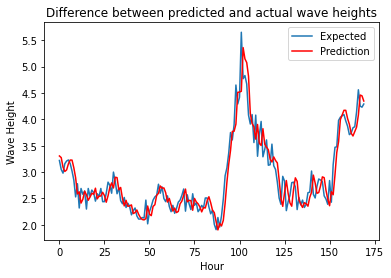

In [21]:
X = df_arima_wvht.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0)) # (5,0,0) was determined to be the best ARIMA by trial and error MAYBE 5 ISNT THE BEST, THIS IS THE NUMBER OF HISTORICAL POINTS USED
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
mae = mean_absolute_error(test, predictions)
r_sq = r2_score(test, predictions)
print('Test MAE: ', mae)
print('Test R^2: ', r_sq)
# plot
plt.plot(test, label='Expected')
plt.plot(predictions, color='red', label='Prediction')
plt.xlabel('Hour')
plt.ylabel('Wave Height')
plt.title('Difference between predicted and actual wave heights')
plt.legend()
plt.show();

In [22]:
# Lets try facebooks prophet model
df.tail()
df_keep = df.copy()
# 2017 is at the bottom of the dataframe, so the most recent info is last, Is this correct?

In [23]:
# for the prophet model, we need two columns. One is 'ds' which is the date as a datetime, and the other is 'y' which is our target
df = df.reset_index()
df.rename(columns = {'Date':'ds', 'WVHT':'y'}, inplace = True) 
df.drop(columns=['MM', 'hh', 'WDIR', 'WSPD', 'GST', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'Temp_diff'], inplace=True)
df['y'] = np.log(df['y']) # This is to make the data stationary MIGHT NOT BE NEEDED (this did seem to help)(might have also made negative wave heights possible, incorrect scale?)
df.head()

,ds,y
0,2013-01-01 00:50:00,1.311032
1,2013-01-01 01:50:00,1.393766
2,2013-01-01 02:50:00,1.451614
3,2013-01-01 03:50:00,1.406097
4,2013-01-01 04:50:00,1.396245


In [24]:
# Split the data into data frames for testing and training
# Train : 12/31/2016
# Test : 12/31/2017

cutoff1 = '12/31/2016'

mask1 = df.ds < cutoff1

df_train = df.loc[mask1]
df_test = df.loc[~mask1]

print(len(df_train))
print(len(df_test))

32047
8666


In [25]:
df_test.head()
# Still need to remove the y in order to make a test data frame of only the future dates that we would like to predict
# Note, we have the actual data for these measurments, they are just removed
# We might want to save the column 'y' for use later in evaluating metrics
df_test.drop(columns='y', inplace=True)
df_test.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds
32047,2016-12-31 00:50:00
32048,2016-12-31 01:50:00
32049,2016-12-31 02:50:00
32050,2016-12-31 03:50:00
32051,2016-12-31 04:50:00


In [26]:
model = Prophet() # Inside the () you could put growth='logistic' to change the regression but for now its linear
# fit the model
model.fit(df_train)

                   ds      yhat  yhat_lower  yhat_upper
0 2016-12-31 00:50:00  1.112333    0.733340    1.468569
1 2016-12-31 01:50:00  1.115067    0.731904    1.451231
2 2016-12-31 02:50:00  1.116709    0.763627    1.508473
3 2016-12-31 03:50:00  1.115857    0.746600    1.501793
4 2016-12-31 04:50:00  1.113118    0.763781    1.488589


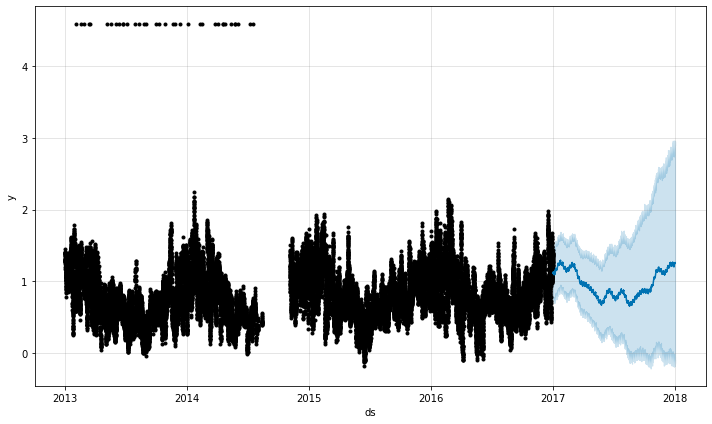

In [27]:
# use the model to make a forecast
forecast = model.predict(df_test)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()) #yhatlower and yahtupper are basically the confidence intervals that arent actually confidence intervals
# plot forecast
from matplotlib import pyplot
model.plot(forecast)
pyplot.show()

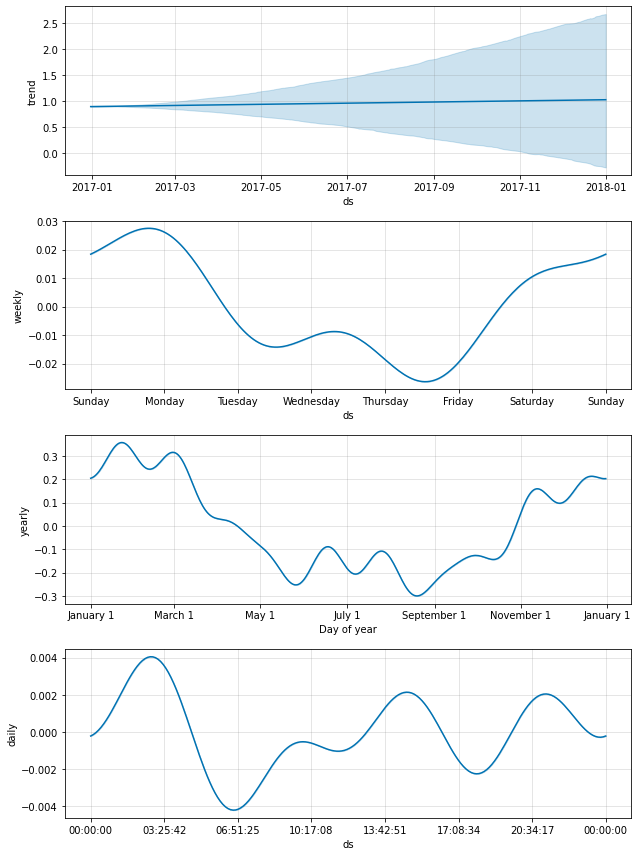

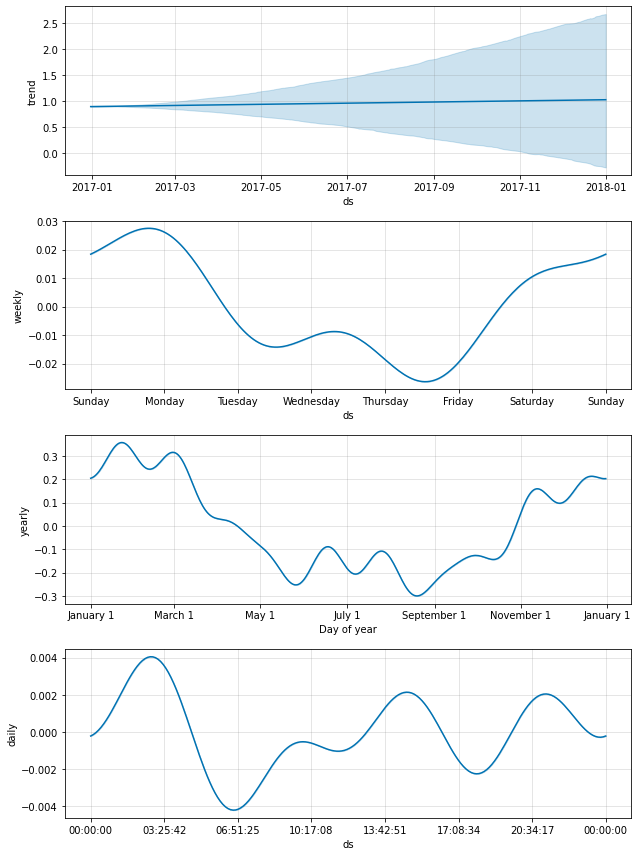

In [28]:
model.plot_components(forecast)

In [29]:
# Attempt to try to get a better model
model2 = Prophet(growth='linear',
                  yearly_seasonality=True,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=None)
model2.fit(df_train)

In [30]:
# Looking at monthly predictions, this might need more data collection in order to work.
future2 = model2.make_future_dataframe(periods=24, freq='M', include_history=True) # include history is used to try the model out on the historical data as well. 


In [31]:
forecast2 = model2.predict(future2)

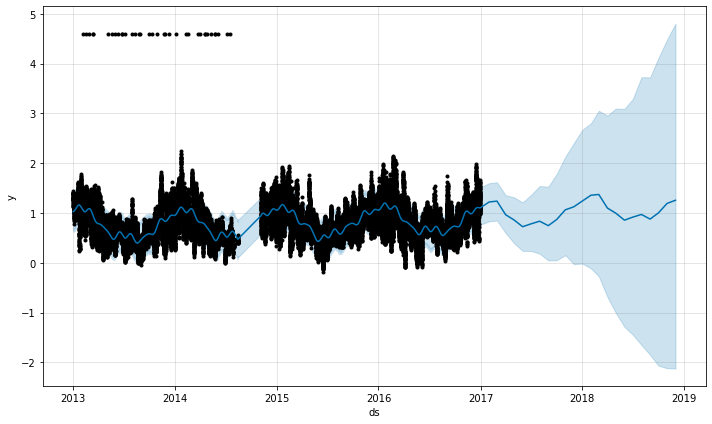

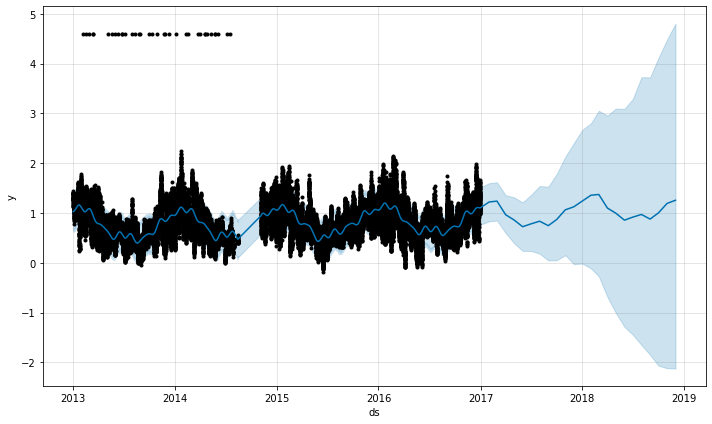

In [32]:
model2.plot(forecast2)

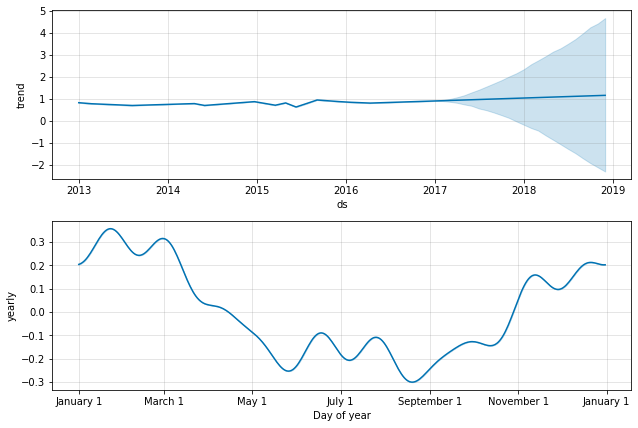

In [33]:
model.plot_components(forecast2);

In [34]:
# Metrics for the Prophet model
# We need to bring back in the actual results 'y' that was removed from the df_test set
# This might be tough for the monthly one as the time might not match up

df_merge = pd.merge(df, forecast)
print(len(df))
print(len(forecast))
df_merge = df_merge[['ds', 'y', 'yhat']]
df_merge.head()

40713
8666


,ds,y,yhat
0,2016-12-31 00:50:00,1.105257,1.112333
1,2016-12-31 01:50:00,1.144223,1.115067
2,2016-12-31 02:50:00,1.128171,1.116709
3,2016-12-31 03:50:00,1.118415,1.115857
4,2016-12-31 04:50:00,1.088562,1.113118


In [35]:
model_prophet_mae = mean_absolute_error(df_merge.y, df_merge.yhat)

print('Prophet Model:')
print('Test MAE:', model_prophet_mae)


Prophet Model:
Test MAE: 0.30484439952775


In [36]:
# Checking the model R^2 value for the prophet model
model_prophet_r2 = r2_score(df_merge.y, df_merge.yhat)
# model_lr_r2_score_val = r2_score(X_val, y_val)

print('Prophet Model:')
print('Test R^2:', model_prophet_r2)

Prophet Model:
Test R^2: -0.15346642988379955


In [37]:
# This is where a XGboost prediction model is created

In [38]:
df_keep.head()

,MM,hh,WDIR,WSPD,GST,WVHT,APD,MWD,PRES,ATMP,WTMP,Temp_diff
Date,,,,,,,,,,,,
2013-01-01 00:50:00,1,0,345,10.3,12.0,3.71,8.79,314,1017.4,22.1,24.1,2.0
2013-01-01 01:50:00,1,1,357,9.4,11.8,4.03,9.16,330,1017.9,22.4,24.1,1.7
2013-01-01 02:50:00,1,2,351,9.9,12.1,4.27,9.09,327,1018.7,22.3,24.1,1.8
2013-01-01 03:50:00,1,3,358,10.4,12.3,4.08,8.50,326,1019.3,22.1,24.1,2.0
2013-01-01 04:50:00,1,4,354,9.7,11.5,4.04,8.74,318,1020.0,21.9,24.1,2.2


In [39]:
df_keep.drop(columns='hh', inplace=True)

In [40]:
# I would like to make a previous column for the previous wave height reading
df_keep['1 lag WVHT'] = df_keep['WVHT'].shift(1)
df_keep['2 lag WVHT'] = df_keep['WVHT'].shift(2)
df_keep['3 lag WVHT'] = df_keep['WVHT'].shift(3)

In [41]:
df_keep.dropna(inplace=True)
df_keep.head()


,MM,WDIR,WSPD,GST,WVHT,APD,MWD,PRES,ATMP,WTMP,Temp_diff,1 lag WVHT,2 lag WVHT,3 lag WVHT
Date,,,,,,,,,,,,,,
2013-01-01 03:50:00,1,358,10.4,12.3,4.08,8.50,326,1019.3,22.1,24.1,2.0,4.27,4.03,3.71
2013-01-01 04:50:00,1,354,9.7,11.5,4.04,8.74,318,1020.0,21.9,24.1,2.2,4.08,4.27,4.03
2013-01-01 05:50:00,1,355,10.5,12.5,4.04,8.51,323,1020.9,21.7,24.1,2.4,4.04,4.08,4.27
2013-01-01 06:50:00,1,357,9.4,11.7,4.00,8.82,328,1021.3,21.7,24.1,2.4,4.04,4.04,4.08
2013-01-01 07:50:00,1,348,9.2,11.8,4.10,8.79,333,1021.4,21.4,24.0,2.6,4.00,4.04,4.04


In [42]:
# Create a target and a feature matrix
target = 'WVHT'
y = df_keep[target]
X = df_keep.drop(columns=target)

In [43]:
# Train : 12/31/2015
# Validate : 12/31/2016
# Test : 12/31/2017

cutoff1 = '12/31/2015'
cutoff2 = '12/31/2016'

mask1 = X.index < cutoff1

X_train, y_train = X.loc[mask1], y.loc[mask1]
X, y = X.loc[~mask1], y.loc[~mask1]

mask2 = X.index < cutoff2
X_val, y_val = X.loc[mask2], y.loc[mask2]
X_test, y_test = X.loc[~mask2], y.loc[~mask2]

In [44]:
# XGB Regression model
eval_set = [(X_val, y_val)]

model_xgb = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=42, n_jobs=-1, eval_set=eval_set, eval_metric='logloss', early_stopping_rounds=10, verbose=True) # We can use n_jobs because things are being done in parallel 
)
model_xgb.fit(X_train, y_train);

[20:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [45]:
# Checking the model metrics
model_xgb_training_mae = mean_absolute_error(y_train, model_xgb.predict(X_train))
model_xgb_validation_mae = mean_absolute_error(y_val, model_xgb.predict(X_val))

print('XGB Regression Model:')
print('Training MAE:', model_xgb_training_mae)
print('Validation MAE:', model_xgb_validation_mae)

XGB Regression Model:
Training MAE: 0.11008052968455245
Validation MAE: 0.12384462089424988


In [46]:
# Checking the model R^2 value
model_xgb_r2_score_train = model_xgb.score(X_train, y_train)
model_xgb_r2_score_val = model_xgb.score(X_val, y_val)


print('XGB Regression Model:')
print('Train XGB Regression R^2:', model_xgb_r2_score_train)
print('Val XGB Regression R^2:', model_xgb_r2_score_val)

XGB Regression Model:
Train XGB Regression R^2: 0.9984684928820767
Val XGB Regression R^2: 0.9663534124911995


In [47]:
# Need to do a testing MAE/R^2
model_xgb_test_mae = mean_absolute_error(y_test, model_xgb.predict(X_test))
model_xgb_r2_score_test = model_xgb.score(X_test, y_test)

print('TEST MAE:', model_xgb_test_mae)
print('TEST XGB Regression R^2:', model_xgb_r2_score_test)

TEST MAE: 0.11209198116788462
TEST XGB Regression R^2: 0.9646069707403347


In [48]:
# I need a plot
X_test['Predict'] = model_xgb.predict(X_test)
X_test['Actual'] = y_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
Predict = X_test['Predict'][:8000]
Actual = X_test['Actual'][:8000]

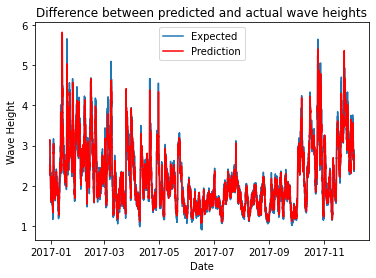

In [50]:
plt.plot(Actual, label='Expected')
plt.plot(Predict, color='red', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Wave Height')
plt.title('Difference between predicted and actual wave heights')
plt.legend()
plt.show();